In [110]:
#imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt

In [111]:
df = pd.read_csv('mydata/movie/train.csv', index_col='id')

In [112]:
#look at numeric data
df.describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


Insights: 1) Budget=0 and runtime=0 is not possible

In [113]:
#check missing data
df.isna().sum().sort_values()

revenue                     0
release_date                0
status                      0
original_title              0
original_language           0
popularity                  0
budget                      0
imdb_id                     0
title                       0
poster_path                 1
runtime                     2
genres                      7
overview                    8
cast                       13
crew                       16
spoken_languages           20
production_countries       55
production_companies      156
Keywords                  276
tagline                   597
homepage                 2054
belongs_to_collection    2396
dtype: int64

In [114]:
#fix missing data and =0 for numeric features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for column in df.select_dtypes(include=numerics).columns:
    df[column].replace(np.nan, df[column].median(), inplace=True)

df.loc[df.budget==0, "budget"] = df.budget.median()
df.loc[df.runtime==0,"runtime"] = df.runtime.median()

C:\Users\FArnold\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  
C:\Users\FArnold\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:7620: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)


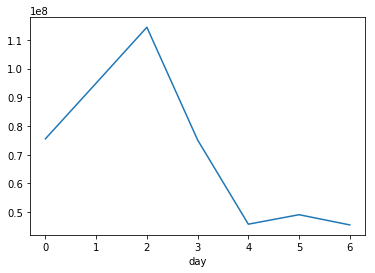

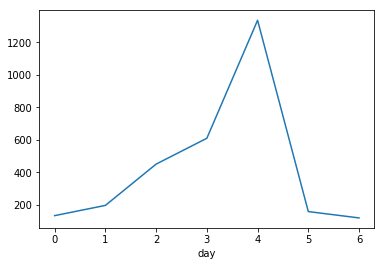

In [115]:
#analyse release date
releaseDate = pd.to_datetime(df['release_date']) 
df["day"] = releaseDate.dt.dayofweek
year = releaseDate.dt.year
#some years are >2020 --> subtract 100
year[year>2020] = year[year>2020]-100

df.groupby("day").revenue.mean().plot()
plt.show()
df.groupby("day").day.count().plot()
plt.show()

Insight: Revenue on movies releases Friday to Saturday is lower

In [116]:
#construct new feature for weekends and age
df["releasedOnWeekend"] = df["day"] >=4
df["Age"] = year.max() - year

In [117]:
#analyse Genres
#idea: construct binary features of those genres with mean revenue significantly different from average revenue
#1) create list of all mentioned genres
df.genresList = df.genres.str.strip('[]')
df.genresList[df.genresList.isnull()] = ''
genres_list = pd.Series(list(set(", ".join(df.genresList.unique().tolist()).split('}, ')))).str.split("'name': '").str[1].str.split("'").str[0].tolist()
#2) create a dataframe with each genre as binary feature
gFrame = pd.DataFrame()
for genre in genres_list:
    gFrame[genre] = df.genres.str.contains(genre)
gFrame["revenue"] = df.revenue
    
#3) do a t-test to find genres with a significant differences
from scipy.stats import ttest_ind
tFrame = pd.DataFrame(columns=["genre","tValue", "count"])
for genre in genres_list:
    testYes = gFrame.loc[gFrame[genre] == True, "revenue"]
    testNo = gFrame.loc[gFrame[genre] == False, "revenue"]
    t, p = ttest_ind(testYes, testNo, equal_var=False)
    tFrame.loc[tFrame.shape[0]] = [genre, p, len(testYes)]
    
#4) select all genres with at least 100 occurences and a significant t-test (p<0.01)
significantGenres = tFrame.loc[(tFrame["tValue"]<0.01) & (tFrame["count"]>100), "genre"].tolist()

#5) create binary features for these genres
gFrame.drop((g for g in genres_list if g not in significantGenres), inplace=True, axis=1)
gFrame.drop("revenue", inplace=True, axis=1)
gFrame = gFrame.fillna(False)

C:\Users\FArnold\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.
C:\Users\FArnold\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\FArnold\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\FArnold\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\FArnold\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value enco

In [118]:
#analyse cast
#idea: construct a binary feature of whether a movie contains a "star" 
#a star is defined as an actor that appeared in 10 or more movies
df.cast[df.cast.isnull()] = ''
castList = df.cast.str.strip('[]')
listOfallActors = pd.Series(pd.Series(list(", ".join(castList.unique().tolist()).split('}, '))).str.split("'name': '").str[1].str.split("'").str[0].tolist())

allActors = listOfallActors.value_counts()
topActors = allActors[allActors>=10].index

df['hasStar'] = df.cast.apply(lambda row: 1 if any(act in row for act in topActors) else 0)
df.groupby("hasStar").revenue.mean()

C:\Users\FArnold\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


hasStar
0    2.704577e+07
1    9.073771e+07
Name: revenue, dtype: float64

Insight: Movies with a star have significantly more revenue

In [119]:
#Feature homepage
df["hashomepage"] = ~(df["homepage"].isna())
df.groupby("hashomepage").revenue.mean()

hashomepage
False    4.216585e+07
True     1.200517e+08
Name: revenue, dtype: float64

Finding: Movies with a hompage have a higher revenue

In [120]:
#Feature belons to collection
df["isinCollection"] = ~(df["belongs_to_collection"].isna())
df.groupby("isinCollection").revenue.mean()

isinCollection
False    4.329159e+07
True     1.596869e+08
Name: revenue, dtype: float64

Finding: Movies that are part of a collection have a higher revenue

In [121]:
#normalize the budget
budgetPerYear = df.groupby(releaseDate.dt.year).budget.mean()
yearBudget = budgetPerYear[year]
df["normalizedBudget"] = df["budget"].div(yearBudget.values)
df["normalizedBudget"]= df["normalizedBudget"].fillna(1)

C:\Users\FArnold\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [122]:
#construct the dataframe for all features
target = df["revenue"]
df["budgetlog"] = np.log1p(df["budget"])
df["popularitylog"] = np.log1p(df["popularity"])
#usedfeatures = ['budgetlog', 'popularitylog', 'runtime', 'releasedOnWeekend', 'Age','hasStar', "hashomepage", "isinCollection"]
usedfeatures = ['budgetlog', "normalizedBudget", 'popularitylog', 'runtime', 'releasedOnWeekend', 'Age','hasStar', "hashomepage", "isinCollection"]
features = df[usedfeatures]
features = features.merge(gFrame, on=['id'], how='left')
features.head(2)

,budgetlog,normalizedBudget,popularitylog,runtime,releasedOnWeekend,Age,hasStar,hashomepage,isinCollection,Drama,Fantasy,Family,History,Adventure,Animation,Science Fiction,Horror,Action,Romance
id,,,,,,,,,,,,,,,,,,,
1,16.454568,0.435821,2.024905,93.0,True,2,1,False,True,False,False,False,False,False,False,False,False,False,False
2,17.504390,1.184914,2.224504,113.0,True,13,0,False,True,True,False,True,False,False,False,False,False,False,True


In [123]:
#build a regression model
def average(list):
    return sum(list)/len(list)

results = []
for x in range(10):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=x)
    reg = LinearRegression()
    reg.fit(X_train, np.log1p(y_train))
    y_pred = np.exp(reg.predict(X_test))-1
    eval = np.sqrt(mean_squared_log_error(y_pred, y_test))
    print("Coefficients %n" , reg.coef_)
    results.append(eval)
    #reg.get_params()

average(results)

Coefficients %n [ 0.56315675  0.15419511  1.37897111  0.01880221  0.06778496  0.01871888
  0.38710607  0.26985961  0.78634436 -0.33945547 -0.11475987  0.6000318
 -0.01637266  0.15123388  0.43508816 -0.07699976  0.20719493  0.13155788
  0.50714157]
Coefficients %n [ 0.58221275  0.17209478  1.37115794  0.01482701  0.04710801  0.01976632
  0.45645846  0.22957211  0.74440928 -0.36171359 -0.08791225  0.71141012
 -0.05728311  0.09890907  0.0710443  -0.0735967   0.24332562  0.15322581
  0.43345766]
Coefficients %n [ 0.49165594  0.20381543  1.33889336  0.0149318   0.027768    0.01976905
  0.5113542   0.30473528  0.75644267 -0.29472926  0.00873648  0.71870308
  0.08210163  0.09958859  0.12124121 -0.1120229   0.30675143  0.10198873
  0.45046477]
Coefficients %n [ 0.46607008  0.22603439  1.3116436   0.01509531  0.00642726  0.01920862
  0.52801895  0.234179    0.74656761 -0.31733968 -0.03268621  0.62052019
  0.12132754  0.11617969  0.1783507  -0.04497746  0.15988487  0.07902367
  0.27685768]
Coeff

2.259858583592308